In [1]:
import numpy as np
import random
import math
import h5py
import gc
import sys
import matplotlib.mlab as mlab
import pylab as pl
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle

In [2]:
import tensorflow as tf

In [3]:
hdf_file = 'datasets/pickles/SVHN_multi_box.hdf5'

hdf = h5py.File(hdf_file,'r')
svhn_train_box_dataset = hdf['train_images'][:]
svhn_train_box_labels = hdf['train_labels'][:]
svhn_test_box_dataset = hdf['test_images'][:]
svhn_test_box_labels = hdf['test_labels'][:]
svhn_valid_box_dataset = hdf['valid_images'][:]
svhn_valid_box_labels = hdf['valid_labels'][:]
            
hdf.close()    

print(svhn_train_box_dataset.shape, svhn_train_box_labels.shape)
print(svhn_test_box_dataset.shape, svhn_test_box_labels.shape)
print(svhn_valid_box_dataset.shape, svhn_valid_box_labels.shape)

(229087, 32, 96, 1) (229087, 6)
(13068, 32, 96, 1) (13068, 6)
(6666, 32, 96, 1) (6666, 6)


In [4]:
def plot_img(im, label):
    if len(im.shape) >= 3:
        im = im[:,:,0]
    plt.imshow(im)
    plt.title(label)
    plt.show()
    
def plot(i, d=0):
    if d == 2:
        plot_img(svhn_valid_box_dataset[i], svhn_valid_box_labels[i])
    elif d == 1:
        plot_img(svhn_test_box_dataset[i], svhn_test_box_labels[i])
    else :
        plot_img(svhn_train_box_dataset[i], svhn_train_box_labels[i])

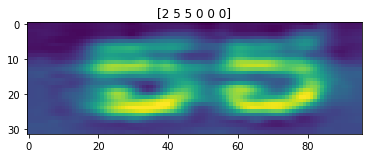

In [5]:
plot(16)

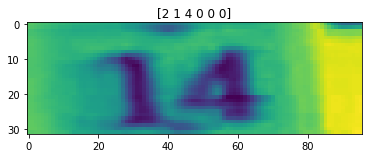

In [6]:
plot(46, 1)

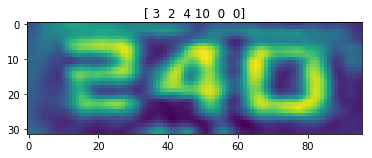

In [10]:
plot(25, 2)

In [11]:
def get_label_dist(labels_data):
    ddict = {}
    for i in range(labels_data.shape[0]):
        l = labels_data[i][0]
        if not l in ddict:
            ddict[l] = 0
        ddict[l] = ddict[l] + 1
    return ddict

In [12]:
train_label_dict = get_label_dist(svhn_train_box_labels)
test_label_dict = get_label_dist(svhn_test_box_labels)
valid_label_dict = get_label_dist(svhn_valid_box_labels)

In [13]:
def hist_dict(dict) :
    dict = OrderedDict(sorted(dict.items()))
    X = np.arange(len(dict))
    pl.bar(X, dict.values(), align='center', width=0.5)
    pl.xticks(X, dict.keys())
    ymax = max(dict.values()) + 1000
    pl.ylim(0, ymax)
    pl.show()

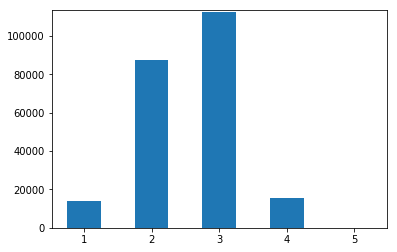

In [14]:
hist_dict(train_label_dict)

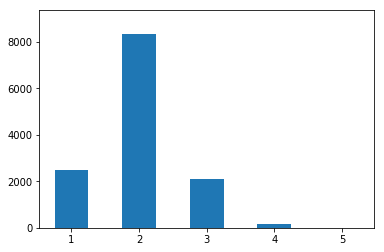

In [15]:
hist_dict(test_label_dict)

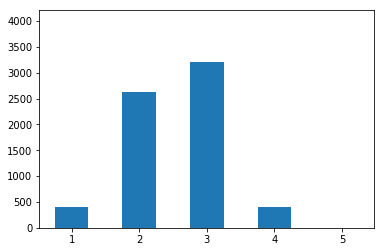

In [16]:
hist_dict(valid_label_dict)

In [17]:
def acc(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [18]:
def randomize_dataset(images, labels):
    shuffle = list(zip(images, labels))
    np.random.shuffle(shuffle)
    i, l = zip(*shuffle)
    i, l = np.asarray(i), np.asarray(l)
    return i, l

In [19]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [20]:
svhn_train_box_dataset = svhn_train_box_dataset.astype(np.float32)
svhn_test_box_dataset = svhn_test_box_dataset.astype(np.float32)
svhn_valid_box_dataset = svhn_valid_box_dataset.astype(np.float32)

svhn_train_box_labels = svhn_train_box_labels.astype(np.int32)
svhn_test_box_labels = svhn_test_box_labels.astype(np.int32)
svhn_valid_box_labels = svhn_valid_box_labels.astype(np.int32)

In [21]:
model_to_save = "saved_models/box/CNN_SVHN_Box.ckpt"

In [22]:
graph_svhn = tf.Graph()

with graph_svhn.as_default():
    HEIGHT = 32
    WIDTH = 32*3

    X = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1])
    Y_ = tf.placeholder(tf.int32, [None, 6])
    
    # Learning Rate - alpha
    alpha = tf.placeholder(tf.float32)
    
    # Dropout Probablity
    pkeep = tf.placeholder(tf.float32)
    
    # 6 Layers and their no of neurons
    # 3 Convolutional Layers and a fully connected layer
    K = 12     # First Conv Layer with depth 12
    L = 24     # Second Conv Layer with depth 24
    M = 36    # Third Conv layer with depth 36
    N = 300   # Fourth Fully Connected layer with 300 neurons
    P = 200   # Fifth Fully Connected layer with 200 neurons
    # Last one will be softmax layer with 10 output channels
    
    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1), name="W1")    # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]), name="B1")
    
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1), name="W2")
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]), name="B2")
    
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1), name="W3")
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]), name="B3")
    
    W5_1 = tf.Variable(tf.truncated_normal([P, 11], stddev=0.1), name="W5_1")
    B5_1 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_1")
    
    W5_2 = tf.Variable(tf.truncated_normal([P, 11], stddev=0.1), name="W5_2")
    B5_2 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_2")
    
    W5_3 = tf.Variable(tf.truncated_normal([P, 11], stddev=0.1), name="W5_3")
    B5_3 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_3")
    
    W5_4 = tf.Variable(tf.truncated_normal([P, 11], stddev=0.1), name="W5_4")
    B5_4 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_4")
    
    W5_5 = tf.Variable(tf.truncated_normal([P, 11], stddev=0.1), name="W5_5")
    B5_5 = tf.Variable(tf.constant(0.1, tf.float32, [11]), name="B5_5")
    
    # Model
    stride = 1  # output is 32x96
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    
    stride = 2  # output is 16x48
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    
    stride = 2  # output is 8x24
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

    # reshape the output from the third convolution for the fully connected layer
    shape = Y3.get_shape().as_list()
    YY = tf.reshape(Y3, shape=[-1, shape[1] * shape[2] * shape[3]])
    
    W4 = tf.Variable(tf.truncated_normal([shape[1] * shape[2] * shape[3], N], stddev=0.1), name="W4")
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]), name="B4")
    
    W5 = tf.Variable(tf.truncated_normal([N, P], stddev=0.1), name="W5")
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [P]), name="B5")

    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
    Y5 = tf.nn.relu(tf.matmul(Y4, W5) + B5)
    
    Y_F = tf.nn.dropout(Y5, pkeep)
    
    Ylogits_1 = tf.matmul(Y_F, W5_1) + B5_1
    Ylogits_2 = tf.matmul(Y_F, W5_2) + B5_2
    Ylogits_3 = tf.matmul(Y_F, W5_3) + B5_3
    Ylogits_4 = tf.matmul(Y_F, W5_4) + B5_4
    Ylogits_5 = tf.matmul(Y_F, W5_5) + B5_5   
    ## ('Ylogits_1 shape : ', [None, 11])
    
    Y_1 = tf.nn.softmax(Ylogits_1)
    Y_2 = tf.nn.softmax(Ylogits_2)
    Y_3 = tf.nn.softmax(Ylogits_3)
    Y_4 = tf.nn.softmax(Ylogits_4)
    Y_5 = tf.nn.softmax(Ylogits_5)
   
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_1, Y_[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_2, Y_[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_3, Y_[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_4, Y_[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(Ylogits_5, Y_[:,5]))

    train_prediction = tf.pack([Y_1, Y_2, Y_3, Y_4, Y_5])
    
    train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)
    
    W_s = tf.pack([tf.reduce_max(tf.abs(W1)),tf.reduce_max(tf.abs(W2)),tf.reduce_max(tf.abs(W3))\
                   ,tf.reduce_max(tf.abs(W4)),tf.reduce_max(tf.abs(W5))])
    b_s = tf.pack([tf.reduce_max(tf.abs(B1)),tf.reduce_max(tf.abs(B2)),tf.reduce_max(tf.abs(B3))\
                   ,tf.reduce_max(tf.abs(B4)),tf.reduce_max(tf.abs(B5))])
    
    model_saver = tf.train.Saver()

In [23]:
train_data = svhn_train_box_dataset
label_data = svhn_train_box_labels
print('train : ', train_data.shape, '  test : ', label_data.shape)

box_train_dict = {}
batch_size = 128
num_steps = int(label_data.shape[0] / batch_size)
num_epochs = 25

with tf.Session(graph=graph_svhn) as session:
    tf.global_variables_initializer().run()
    print('Initialized')

    test_batch = int(svhn_test_box_labels.shape[0]/num_epochs)
    test_acc = list()
    
    for epoch in range(num_epochs - 1):
        res_epoch = {}
        t_data = svhn_test_box_dataset[epoch*test_batch:(epoch+1)*test_batch]
        t_label = svhn_test_box_labels[epoch*test_batch:(epoch+1)*test_batch]
        
        for step in range(num_steps - 1):
            max_learning_rate = 0.0005
            min_learning_rate = 0.0001

            decay_speed = 5000.0
            learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)

            batch_data = train_data[step*batch_size:(step + 1)*batch_size, :, :, :]
            batch_labels = label_data[step*batch_size:(step + 1)*batch_size, :]

            feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
            _, l, train_pred, W, b = session.run([train_step, cross_entropy, train_prediction, W_s, b_s], feed_dict=feed_dict)
            accuracy = float(acc(train_pred, batch_labels[:,1:6]))

            if (step % 500 == 0):
                minibatch = {}
                minibatch['loss'] = l
                minibatch['W'] = W
                minibatch['B'] = b
                minibatch['accuracy'] = "%.2f" % accuracy

                res_epoch[int(step/500)] = minibatch
                print('Loss at step %d: %f' % (step, l))
                print('Minibatch accuracy: %.1f%%' % acc(train_pred, batch_labels[:,1:6]))
                print('    ')
                
        box_train_dict[epoch+1] = res_epoch

        epoch_acc = 0
        for f in res_epoch:
            minibatch = res_epoch[f]
            epoch_acc += float(minibatch['accuracy'])
        epoch_acc = float(epoch_acc/len(res_epoch))
        
        _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : t_data, Y_ : t_label, pkeep : 1.0, alpha : 0.002})
        accuracy = float(acc(predictions, t_label[:,1:6]))
        test_acc.append(accuracy)

        print('------------------------------------')
        print('Epoch',epoch+1,' Complete with accuracy: %.2f%%' % epoch_acc)
        print('Epoch',epoch+1,' Test Accuracy : %.2f%%' % accuracy)
        print('------------------------------------')
        print('        ')
            
    print('Training Complete on MNIST Data')
    print('Test Accuracy : ', mean(test_acc))
    
    save_path = model_saver.save(session, model_to_save)
    print("Model saved in file: %s" % save_path)

train :  (229087, 32, 96, 1)   test :  (229087, 6)
Initialized
Loss at step 0: 45.336151
Minibatch accuracy: 5.6%
    
Loss at step 500: 2.658956
Minibatch accuracy: 81.6%
    
Loss at step 1000: 2.351891
Minibatch accuracy: 86.1%
    
Loss at step 1500: 1.529872
Minibatch accuracy: 90.0%
    
------------------------------------
Epoch 1  Complete with accuracy: 65.82%
Epoch 1  Test Accuracy : 89.92%
------------------------------------
        
Loss at step 0: 1.828797
Minibatch accuracy: 89.5%
    
Loss at step 500: 0.879863
Minibatch accuracy: 94.1%
    
Loss at step 1000: 1.217661
Minibatch accuracy: 92.7%
    
Loss at step 1500: 0.923918
Minibatch accuracy: 94.2%
    
------------------------------------
Epoch 2  Complete with accuracy: 92.62%
Epoch 2  Test Accuracy : 92.99%
------------------------------------
        
Loss at step 0: 0.966516
Minibatch accuracy: 93.6%
    
Loss at step 500: 0.657550
Minibatch accuracy: 95.8%
    
Loss at step 1000: 0.910753
Minibatch accuracy: 9

In [24]:
file = 'results/Box.pickle'

with open(file, 'wb') as handle:
    pickle.dump(box_train_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
with tf.Session(graph=graph_svhn) as session: 
    print('Initialized')
    batch = 1000
    
    valid_acc = list()
    valid_no = int(svhn_valid_box_labels.shape[0] /  batch)
    for i in range(valid_no - 1):
        model_saver.restore(session, model_to_save)
        data = svhn_valid_box_dataset[i*batch:(i+1)*batch]
        labels = svhn_valid_box_labels[i*batch:(i+1)*batch]
        
        _, l, predictions = session.run([train_step, cross_entropy, train_prediction], feed_dict={X : data, Y_ : labels, pkeep : 1.0, alpha : 0.002})
        accuracy = acc(predictions, labels[:,1:6])
        valid_acc.append(accuracy)
        
        print('Valid-Accuracy', ' Batch : ', i*1000)
        print('Valid accuracy: ', accuracy)
        print('        ')
            
    valid_avg = mean(valid_acc)
    
    print('-----  FINAL  ------')
    print('Final Validation Set Accuracy : ',"%.2f" % valid_avg)

Initialized
Valid-Accuracy  Batch :  0
Valid accuracy:  96.4
        
Valid-Accuracy  Batch :  1000
Valid accuracy:  96.8
        
Valid-Accuracy  Batch :  2000
Valid accuracy:  96.58
        
Valid-Accuracy  Batch :  3000
Valid accuracy:  96.64
        
Valid-Accuracy  Batch :  4000
Valid accuracy:  95.82
        
-----  FINAL  ------
Final Validation Set Accuracy :  96.45
